In [2]:
from __future__ import division

import re
import math
import nltk
import string
import random
import codecs
import numpy as np
import itertools as it
import tensorflow as tf
import cPickle as pickle
import scipy.sparse as ss
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
def load_corpus(file_path):
    """ Load corpus from text file and tokenize """
    corpus = []
    vocab_cnt = Counter()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    
    with codecs.open(file_path, 'r', encoding='utf-8') as fd:
        for line in fd:
            # clean lines from any punctuation characters
            clean_line = re.sub('[\+\-\.\,\:\;\"\?\!\>\<\=\(\)\n]+', '', line)
            tokens = tokenizer.tokenize(clean_line.lower())
            corpus.append(tokens)
            vocab_cnt.update(tokens)
            
    return corpus, vocab_cnt


def code_tokens(vocab_cnt, max_size=30000, unk_symbol='<unk>'):
    """ Filter vocabulary and encode tokens """
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>']
    vocab.extend([word for word, _ in vocab_cnt.most_common(max_size)])
    vocab_enc = {token: ix for ix, token in enumerate(vocab)}
    vocab_dec = {ix: token for token, ix in vocab_enc.iteritems()}
    
    return vocab, vocab_enc, vocab_dec


def generate_context_data(corpus, max_window_size=5, skip_size=1, flatten=True):
    """ Generate data with context in format (target, [contexts]) or (target, context) """
    for center_ix in xrange(max_window_size, len(corpus)-max_window_size, skip_size):
        # sample a window size for the given center word
        window_size = np.random.randint(max_window_size) + 1
        full_context = corpus[center_ix-window_size:center_ix] + corpus[center_ix+1: center_ix+window_size+1]
        
        if flatten:
            for context_ix in xrange(2*window_size):
                yield (corpus[center_ix], full_context[context_ix])
        else:
            yield(corpus[center_ix], full_context)


def pad_data(data_arr, append_pre=[], append_suf=[], max_length=None):
    data_arr = [append_pre + row + append_suf for row in data_arr]
    lengths = [len(row) for row in data_arr]
    max_len = max(lengths) if not max_length else max_length
    return np.array([row+[0]*(max_len-length) for row, length in zip(data_arr, lengths)]), lengths
    
                
def batchify_data(data_generator, batch_size):
    """ Split dataset (generator) into batches """
    if isinstance(data_generator, list):
        for ix in xrange(0, len(data_generator), batch_size):
            buff = data_generator[ix:ix+batch_size]
            yield buff
    else:
        while data_generator:
            buff = []
            for ix in xrange(0, batch_size):
                buff.append(next(data_generator))
            yield buff


def save_embeddings(embeddings_obj, file_name):
    """ Save word embeddings and helper structures """
    with open(file_name, 'wb') as fd:
        pickle.dump(embeddings_obj, fd)
    

def load_embeddings(file_name):
    """ Load word embeddings and helper structures """
    with open(file_name, 'r') as fd:
        embeddings_obj = pickle.load(fd)
    return embeddings_obj
    
    
def get_tsne_embeddings(embedding_matrix):
    """ Compute t-SNE representation of embeddings """
    tsne = TSNE(perplexity=25, n_components=2, init='pca', n_iter=5000)
    return tsne.fit_transform(embedding_matrix)


def get_pca_embeddings(embedding_matrix):
    """ Compute PCA representation of embeddings """
    pca = PCA(n_components=2)
    return pca.fit_transform(embedding_matrix)


def plot_embeddings(embeddings, words=[], words_cnt=500, method='pca', figsize=(8,8)):
    """ Plot subset of embeddings in 2D space using t-SNE or PCA """
    embedding_matrix = embeddings._embeddings
    vocab_dec = embeddings._vocab_dec
    vocab_enc = embeddings._vocab_enc
    
    # prepare data
    if not words:
        vocab_size = embedding_matrix.shape[0]
        ixs = range(vocab_size)
        random.shuffle(ixs)
        chosen_ixs = ixs[:words_cnt]
        labels = [vocab_dec[ix] for ix in chosen_ixs]
        word_vecs = embedding_matrix[chosen_ixs]
    else:
        labels = words
        chosen_ixs = [vocab_enc[word] for word in words]
        word_vecs = embedding_matrix[chosen_ixs]
        
    if method == 'tsne':
        low_dim_embeddings = get_tsne_embeddings(word_vecs)
    else:
        low_dim_embeddings = get_pca_embeddings(word_vecs)
        
    # plot reduced vectors
    plt.figure(figsize=figsize)
    
    for embedding, label in zip(low_dim_embeddings, labels):
        x, y = embedding[0], embedding[1]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), 
                     textcoords='offset points', ha='right', 
                     va='bottom')
    plt.yticks=[]
    plt.xticks=[]
    plt.grid()
    plt.show()
    

class Embeddings(object):
    """ Class wrapping word embeddings """
    def __init__(self, embedding_matrix, vocab_enc, vocab_dec):
        self._embeddings = embedding_matrix
        self._vocab_enc = vocab_enc
        self._vocab_dec = vocab_dec
    
    def find_embedding(self, word):
        """ Find embedding for a given word """
        if isinstance(word, str):
            word = self._vocab_enc[word]
        return self._embeddings[word]
    
    def find_neighbors(self, word, k=5, nearest=True, exclude=[], include_scores=False):
        """ Find neighboring words (semantic regularities) """
        word_ix = self._vocab_enc[word]
        exclude = exclude + [word_ix]
        
        # find neighbors
        word_emb = self._embeddings[word_ix]
        similarities = self._embeddings.dot(word_emb)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1] if nearest else best_matches[:k]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def find_analogous(self, word_a, word_b, word_c, k=5):
        """ Find analogous word (syntactic regularities: word_a - word_b = x - word_c) """
        word_a_ix, word_b_ix, word_c_ix = [self._vocab_enc[word] for word in [word_a, word_b, word_c]]
        exclude = [word_a_ix, word_b_ix, word_c_ix]
        
        emb_a = self.find_embedding(word_a_ix) 
        emb_b = self.find_embedding(word_b_ix) 
        emb_c = self.find_embedding(word_c_ix) 
        emb_d_hat = emb_a - emb_b + emb_c
        similarities = self._embeddings.dot(emb_d_hat)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def vocab(self):
        """ Return vocabulary list """
        return self._vocab_enc.keys()

Corpus A size (total tokens): 177655
Corpus A vocabulary size (distinct tokens): 23614
Most popular words (corpus A): [(u'w', 6558), (u'i', 5091), (u'na', 3013), (u'z', 2633), (u'\u017ce', 2189)]

Corpus B size (total tokens): 209813
Corpus B vocabulary size (distinct tokens): 11012
Most popular words (corpus B): [(u'the', 15602), (u'of', 8042), (u'to', 6611), (u'and', 6587), (u'in', 4925)]


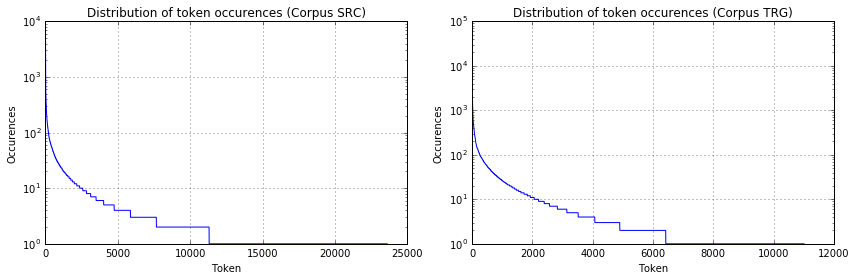

In [4]:
CORPUS_A_PATH, CORPUS_B_PATH = './corpora/europarl.de-en.de', './corpora/europarl.de-en.en'
CORPUS_A_PATH, CORPUS_B_PATH = './corpora/europarl.pl-en.pls', './corpora/europarl.pl-en.ens'

# LOAD CORPUS
corpus_a, vocab_cnt_a = load_corpus(CORPUS_A_PATH)
corpus_b, vocab_cnt_b = load_corpus(CORPUS_B_PATH)

raw_corpus_a_size = sum(vocab_cnt_a.itervalues())
raw_vocab_a_size = len(vocab_cnt_a)
raw_corpus_b_size = sum(vocab_cnt_b.itervalues())
raw_vocab_b_size = len(vocab_cnt_b)

print 'Corpus A size (total tokens):', raw_corpus_a_size
print 'Corpus A vocabulary size (distinct tokens):', raw_vocab_a_size
print 'Most popular words (corpus A):', vocab_cnt_a.most_common(5)
print
print 'Corpus B size (total tokens):', raw_corpus_b_size
print 'Corpus B vocabulary size (distinct tokens):', raw_vocab_b_size
print 'Most popular words (corpus B):', vocab_cnt_b.most_common(5)

# visualize distribution
counts_a = sorted(vocab_cnt_a.itervalues(), reverse=True)
counts_b = sorted(vocab_cnt_b.itervalues(), reverse=True)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.semilogy(range(len(counts_a)), counts_a)
plt.title('Distribution of token occurences (Corpus SRC)')
plt.xlabel('Token')
plt.ylabel('Occurences')
plt.grid()
plt.subplot(122)
plt.semilogy(range(len(counts_b)), counts_b)
plt.title('Distribution of token occurences (Corpus TRG)')
plt.xlabel('Token')
plt.ylabel('Occurences')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
# LIMIT VOCABS
LANG_A_TOKEN_LIMIT = 45000
vocab_a, vocab_enc_a, vocab_dec_a = code_tokens(vocab_cnt_a, LANG_A_TOKEN_LIMIT)
corpus_a_enc = [[vocab_enc_a[word] for word in sentence if word in vocab_enc_a] for sentence in corpus_a]

LANG_B_TOKEN_LIMIT = 25000
vocab_b, vocab_enc_b, vocab_dec_b = code_tokens(vocab_cnt_b, LANG_B_TOKEN_LIMIT)
corpus_b_enc = [[vocab_enc_b[word] for word in sentence if word in vocab_enc_b] for sentence in corpus_b]

print 'Clean corpus A size (total sentences):', len(corpus_a_enc)
print 'Clean corpus A vocabulary size (distinct tokens):', len(vocab_a)
print
print 'Clean corpus B size (total sentences):', len(corpus_b_enc)
print 'Clean corpus B vocabulary size (distinct tokens):', len(vocab_b)

Clean corpus A size (total sentences): 10000
Clean corpus A vocabulary size (distinct tokens): 23618

Clean corpus B size (total sentences): 10000
Clean corpus B vocabulary size (distinct tokens): 11016


Max length diff: 41
Avg length diff: 0.0656


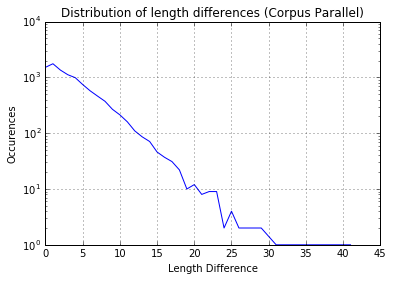

In [6]:
corpus_par = zip(corpus_a_enc, corpus_b_enc)
length_diff = Counter([abs(len(a) - len(b)) for a, b in corpus_par])

print 'Max length diff:', max(length_diff.keys())
print 'Avg length diff:', sum(length_diff.keys()) / len(corpus_par)


keys, values = zip(*sorted(length_diff.iteritems(), key=lambda x: x[0]))
plt.figure(figsize=(6, 4))
plt.semilogy(keys, values)
plt.title('Distribution of length differences (Corpus Parallel)')
plt.xlabel('Length Difference')
plt.ylabel('Occurences')
plt.grid()
plt.show()

In [8]:
# define constant parameters
VOCAB_SIZE_SRC = len(vocab_a)
VOCAB_SIZE_TRG = len(vocab_b)
BATCH_SIZE = 32
MAX_SEQ_LENGTH = 5

EMB_SIZE = 20
ENC_HIDDEN_UNITS = 20
DEC_HIDDEN_UNITS = ENC_HIDDEN_UNITS

# reset graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholders for data
enc_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
enc_inputs_len = tf.placeholder(shape=(None), dtype=tf.int32, name='encoder_inputs_len')
dec_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

# define embeddings and lookup
embeddings_src = tf.Variable(tf.random_uniform([VOCAB_SIZE_SRC, EMB_SIZE], -1.0, 1.0), dtype=tf.float32)
embeddings_trg = tf.Variable(tf.random_uniform([VOCAB_SIZE_TRG, EMB_SIZE], -1.0, 1.0), dtype=tf.float32)
enc_inputs_emb = tf.nn.embedding_lookup(embeddings_src, enc_inputs)

# define encoder
enc_max_time, batch_size = tf.unstack(tf.shape(enc_inputs))
enc_cell = tf.contrib.rnn.GRUCell(ENC_HIDDEN_UNITS)
_, enc_final_state = tf.nn.dynamic_rnn(
    enc_cell, enc_inputs_emb, dtype=tf.float32, time_major=True, scope='encoder_cell')
# additional stuff must be done for attention

# define decoder
dec_cell = tf.contrib.rnn.GRUCell(DEC_HIDDEN_UNITS)
dec_lengths = enc_inputs_len + 3

dec_smax_W = tf.Variable(tf.random_uniform([DEC_HIDDEN_UNITS, VOCAB_SIZE_TRG], -1.0, 1.0), dtype=tf.float32)
dec_smax_b = tf.Variable(tf.zeros([VOCAB_SIZE_TRG]), dtype=tf.float32)

eos_slice = 2*tf.ones([BATCH_SIZE], dtype=tf.int32, name='EOS')
pad_slice = tf.zeros([BATCH_SIZE], dtype=tf.int32, name='PAD')

eos_slice_emb = tf.nn.embedding_lookup(embeddings_src, eos_slice)
pad_slice_emb = tf.nn.embedding_lookup(embeddings_src, pad_slice)

# loop transition function (defines inputs of step t given outputs of step t-1)
# (time, prev_cell_output, prev_cell_state, prev_loop_state) -> (elements_finished, input, cell_state, output, loop_state)
def loop_fn(time, prev_output, prev_state, prev_loop_state):
    if prev_state is None:
        init_elements_finished = (0 >= dec_lengths)
        init_input = eos_slice_emb
        init_cell_state = enc_final_state
        init_cell_output = None
        init_loop_state = None
        return (init_elements_finished, init_input, init_cell_state, init_cell_output, init_loop_state)
    else:
        def get_next_input():
            output_logits = tf.add(tf.matmul(prev_output, dec_smax_W), dec_smax_b)
            pred = tf.argmax(output_logits, axis=1)
            next_input = tf.nn.embedding_lookup(embeddings_trg, pred)
            return next_input

        step_elements_finished = (time >= dec_lengths)
        step_finished = tf.reduce_all(step_elements_finished)
        step_input = tf.cond(step_finished, lambda: pad_slice_emb, get_next_input)
        step_state = prev_state
        step_output = prev_output
        step_loop_state = None
        return (step_elements_finished, step_input, step_state, step_output, step_loop_state)

dec_outputs_ta, dec_final_state, _ = tf.nn.raw_rnn(
    dec_cell, loop_fn)
dec_outputs = dec_outputs_ta.stack()

dec_max_steps, dec_batch_size, dec_dim = tf.unstack(tf.shape(dec_outputs))
dec_outputs_flat = tf.reshape(dec_outputs, (-1, dec_dim))
dec_logits_flat = tf.add(tf.matmul(dec_outputs_flat, dec_smax_W), dec_smax_b)
dec_logits = tf.reshape(dec_logits_flat, (dec_max_steps, dec_batch_size, VOCAB_SIZE_TRG))
dec_preds = tf.argmax(dec_logits, 2)

# define loss function and optimizer
stepwise_cent = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(dec_targets, depth=VOCAB_SIZE_TRG, dtype=tf.float32),
    logits=dec_logits)
loss = tf.reduce_mean(stepwise_cent)
train_op = tf.train.AdamOptimizer().minimize(loss)

Tensor("TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 32, 20), dtype=float32)


In [11]:
sess.run(tf.global_variables_initializer())

try:
    batch_ix = 0
    loss_track = []
    batches_gen = batchify_data(corpus_par, BATCH_SIZE)
    
    for batch_data in batches_gen: 
        # split batch
        batch_src, batch_trg = zip(*batch_data)
        
        # prepare batch
        enc_inc, lengths = pad_data(batch_src)
        max_enc_len = max(lengths)
        batch_trg = [target[:max_enc_len] for target in batch_trg]
        dec_trg, _ = pad_data(batch_trg, append_suf=[2], max_length=max_enc_len+3)
        
        # train
        fd = {
            enc_inputs: enc_inc.T,
            enc_inputs_len: lengths,
            dec_targets: dec_trg.T
        }
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch_ix == 0 or batch_ix % 25 == 0:
            print('batch {}'.format(batch_ix))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(dec_preds, fd)
            for i, (inp, pred) in enumerate(zip(fd[enc_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(' '.join([vocab_dec_a[word].encode('ascii', errors='replace') for word in inp])))
                print('    predicted > {}'.format(' '.join([vocab_dec_b[word].encode('ascii', errors='replace') for word in pred])))
                if i >= 2:
                    break
        batch_ix += 1
                    
except KeyboardInterrupt:
    print 'Training Interrupted'

batch 0
  minibatch loss: 10.2721090317
  sample 1:
    input     > dzia?ania podj?te w wyniku rezolucji parlamentu patrz protok?l <pad> <pad> <pad> <pad>
    predicted > zahradil gmfree fold movements 1950 forged rollcall antiamericanism antiamericanism twofold persecuted <pad> <pad> <pad> <pad>
  sample 2:
    input     > sk?adanie dokument?w patrz protok?? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > add add nicotine celebrates protesting utopian ?ic?u's <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
  sample 3:
    input     > o?wiadczenia pisemne art 116 regulaminu patrz protok?? <pad> <pad> <pad> <pad> <pad>
    predicted > add nicotine seating aged district levy 'integrated furnish judiciary presidencyinoffice <pad> <pad> <pad> <pad> <pad>
batch 25
  minibatch loss: 10.0564146042
  sample 1:
    input     > uk?adu o stowarzyszeniu mi?dzy ue a ameryk? ?rodkow? g?osowanie <pad> <pad> <pad> <pad>
    predicted > reactivate battling battling merits stature journa

batch 150
  minibatch loss: 9.137383461
  sample 1:
    input     > kr?tko m?wi?c ka?dy chce towar?w nikt nie chce transportu <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> to to to to to to to to to to to to to to to to to to to to to to to to to to
  sample 2:
    input     > to oznacza ?e ten sektor kt?ry w rzeczy samej zapewnia bardzo dobre perspektywy zatrudnienia nie cieszy si? zbyt dobr? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the is <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> to to to to to to to to to to to to to to to to
  sample 3:
    input     > jako przedstawiciele obywateli musimy im w pierwszym rz?dzie przypomnie? ?e jest to wa?ny sektor ek

batch 275
  minibatch loss: 8.35770606995
  sample 1:
    input     > we wsp??pracy z komisj? a tak?e indywidualnie w ramach naszego obszaru odpowiedzialno?ci b?dziemy oczywi?cie prezentowa? ?rodki potencjalnie bardziej korzystne kt?re odzwierciedlaj? nasze stanowisko w kwestiach spo?ecznych <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the the the the the the the the the the the the the the the the the the the the the the the the the the the the in in in in in in in in in in in in in in in in in in
  sample 2:
    input     > kwestie te maj? kluczowe znaczenie dla nowoczesnej wsp?lnoty w rodzaju ue uwzgl?dniaj?c odpowiednio kompetencje ue i pa?stw cz?onkowskich <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the the the the the the the the the the the the the the the the the the

batch 425
  minibatch loss: 8.09478282928
  sample 1:
    input     > specjali?ci komisji pragn? dokona? aktualizacji <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the the the the the the the in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in
  sample 2:
    input     > norma m?wi ?e ca?? dawk? mo?na przypisywa? <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the the the the the the the the the in in in in in in in in in in in in in in in in in in in in in in in in in in in in in
  sample 3:
    input     > specjali?ci m?wi? o maksymalnie 10% co oznacza dziesi?ciokrotnie bardziej rygorystyczny wym?g <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

batch 550
  minibatch loss: 8.60911846161
  sample 1:
    input     > musimy sobie to do g?owy <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the the the the the the the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

batch 650
  minibatch loss: 8.02117347717
  sample 1:
    input     > uwa?amy ?e uwzgl?dnienie w traktacie o unii europejskiej funkcjonuj?cej zgodnie z zasadami wi?kszo?ci i kwalifikowanej wi?kszo?ci element?w jednomy?lno?ci kt?re ca?kowicie ca?emu procesowi nie ma ?adnego sensu <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the the the the the the the the the and the the the and the the and the the and the the and the the and the the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
  sample 2:
    input     > jak zapewne pami?ta pan panie przewodnicz?cy w do wspomnia?em ?e posiadanie bomby atomowej ma sens pod warunkiem ?e si? jej nie u?ywa <pad> 

batch 775
  minibatch loss: 8.01319122314
  sample 1:
    input     > panie przewodnicz?cy chcia?abym odnie?? si? do listu w zesz?ym tygodniu w irlandzkiej gazecie narodowej pod kt?rym podpisa?o si? mi?dzy innymi kilku pos??w do tego parlamentu <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
    predicted > the the the the the the the the the the the the the the the the the the the the the the the the the the the the <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
  sample 2:
    input     > sprawa dotyczy tego ?e irlandia b?dzie prawdopodobnie jedynym krajem w kt?rym zostanie przeprowadzone referendum nad tym co obecnie z pewno?ci? zostanie nazwane traktatem <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

## Toy examples

In [ ]:
def toy_data_generator(vocab_size, data_size, max_seq_length):
    for _ in xrange(data_size):
        seq_length = np.random.randint(max_seq_length)+1
        yield [np.random.randint(vocab_size-3)+3 for _ in xrange(seq_length)]

In [ ]:
# define constant parameters
DATA_SIZE = 500000
VOCAB_SIZE = 10
BATCH_SIZE = 32
MAX_SEQ_LENGTH = 5

EMB_SIZE = 20
ENC_HIDDEN_UNITS = 20
DEC_HIDDEN_UNITS = ENC_HIDDEN_UNITS

PAD = vocab_enc_a['<pad>']
SOS = vocab_enc_a['<sos>']
EOS = vocab_enc_a['<eos>']

# define model inputs
enc_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32)
dec_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32)
dec_targets = tf.placeholder(shape=(None, None), dtype=tf.int32)

# define embedding matrix and lookup embeddings
embeddings = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMB_SIZE], -1.0, 1.0), dtype=tf.float32)
enc_inputs_emb = tf.nn.embedding_lookup(embeddings, enc_inputs)
dec_inputs_emb = tf.nn.embedding_lookup(embeddings, dec_inputs)

# define encoder
enc_cell = tf.contrib.rnn.GRUCell(ENC_HIDDEN_UNITS)
_, enc_final_state = tf.nn.dynamic_rnn(
    enc_cell, enc_inputs_emb, dtype=tf.float32, time_major=True, scope='encoder')

# define decoder
dec_cell = tf.contrib.rnn.GRUCell(DEC_HIDDEN_UNITS)
dec_outputs, dec_final_state = tf.nn.dynamic_rnn(
    dec_cell, dec_inputs_emb, initial_state=enc_final_state,
    dtype=tf.float32, time_major=True, scope='decoder')

# define output layer
dec_logits = tf.contrib.layers.linear(dec_outputs, VOCAB_SIZE)
dec_preds = tf.argmax(dec_logits, 2)

# define loss function and optimizer
step_centropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(dec_targets, depth=VOCAB_SIZE, dtype=tf.float32),
    logits=dec_logits)
loss = tf.reduce_mean(step_centropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [ ]:
sess.run(tf.global_variables_initializer())

try:
    batch_ix = 0
    loss_track = []
    batches_gen = batchify_data(toy_data_generator(VOCAB_SIZE, DATA_SIZE, MAX_SEQ_LENGTH), BATCH_SIZE)
    
    for data_batch in batches_gen: 
        enc_inc, lengths = pad_data(data_batch)
        enc_len = lengths
        dec_tar, _ = pad_data(data_batch, append_suf=[2, 0, 0])
        
        fd = {
            enc_inputs: enc_inc.T,
            enc_inputs_len: lengths,
            dec_targets: dec_tar.T
        }
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch_ix == 0 or batch_ix % 1000 == 0:
            print('batch {}'.format(batch_ix))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(dec_preds, fd)
            for i, (inp, pred) in enumerate(zip(fd[enc_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
        batch_ix += 1
                    
except KeyboardInterrupt:
    print 'Training Interrupted'